# Import and Setup Operations

In [ ]:
! pip install astor

In [ ]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.1 MB/s eta 0:00:00


In [ ]:
# Upload files (if not already uploaded)
# Make sure don't reload data again.
# Load these 2 datasets: Debernardi et al 2020 data.csv and Debernardi et al 2020 documentation.csv

from google.colab import files
uploaded = files.upload()

Saving Debernardi et al 2020 data.csv to Debernardi et al 2020 data.csv
Saving Debernardi et al 2020 documentation.csv to Debernardi et al 2020 documentation.csv


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import missingno as msno
from warnings import filterwarnings
filterwarnings('ignore')

# Data Importing

In [ ]:
Pancreatic_Cancer_D = pd.read_csv("Debernardi et al 2020 documentation.csv")
df_D = Pancreatic_Cancer_D.copy()

In [ ]:
Pancreatic_Cancer = pd.read_csv("Debernardi et al 2020 data.csv")
df = Pancreatic_Cancer.copy()

In [ ]:
df_D.head()

,Column name,Original column name,Details
0,sample_id,Sample ID,Unique string identifying each subject
1,patient_cohort,Patient's Cohort,"Cohort 1, previously used samples; Cohort 2, ..."
2,sample_origin,Sample Origin,"BPTB: Barts Pancreas Tissue Bank, London, UK; ..."
3,age,Age,Age in years
4,sex,Sex,"M = male, F = female"


In [ ]:
df.shape # what dimensions

(590, 14)

In [ ]:
df.info() # See the types of variables in the dataset and whether there are any missing observations are observed.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sample_id                590 non-null    object 
 1   patient_cohort           590 non-null    object 
 2   sample_origin            590 non-null    object 
 3   age                      590 non-null    int64  
 4   sex                      590 non-null    object 
 5   diagnosis                590 non-null    int64  
 6   stage                    199 non-null    object 
 7   benign_sample_diagnosis  208 non-null    object 
 8   plasma_CA19_9            350 non-null    float64
 9   creatinine               590 non-null    float64
 10  LYVE1                    590 non-null    float64
 11  REG1B                    590 non-null    float64
 12  TFF1                     590 non-null    float64
 13  REG1A                    306 non-null    float64
dtypes: float64(6), int64(2), o

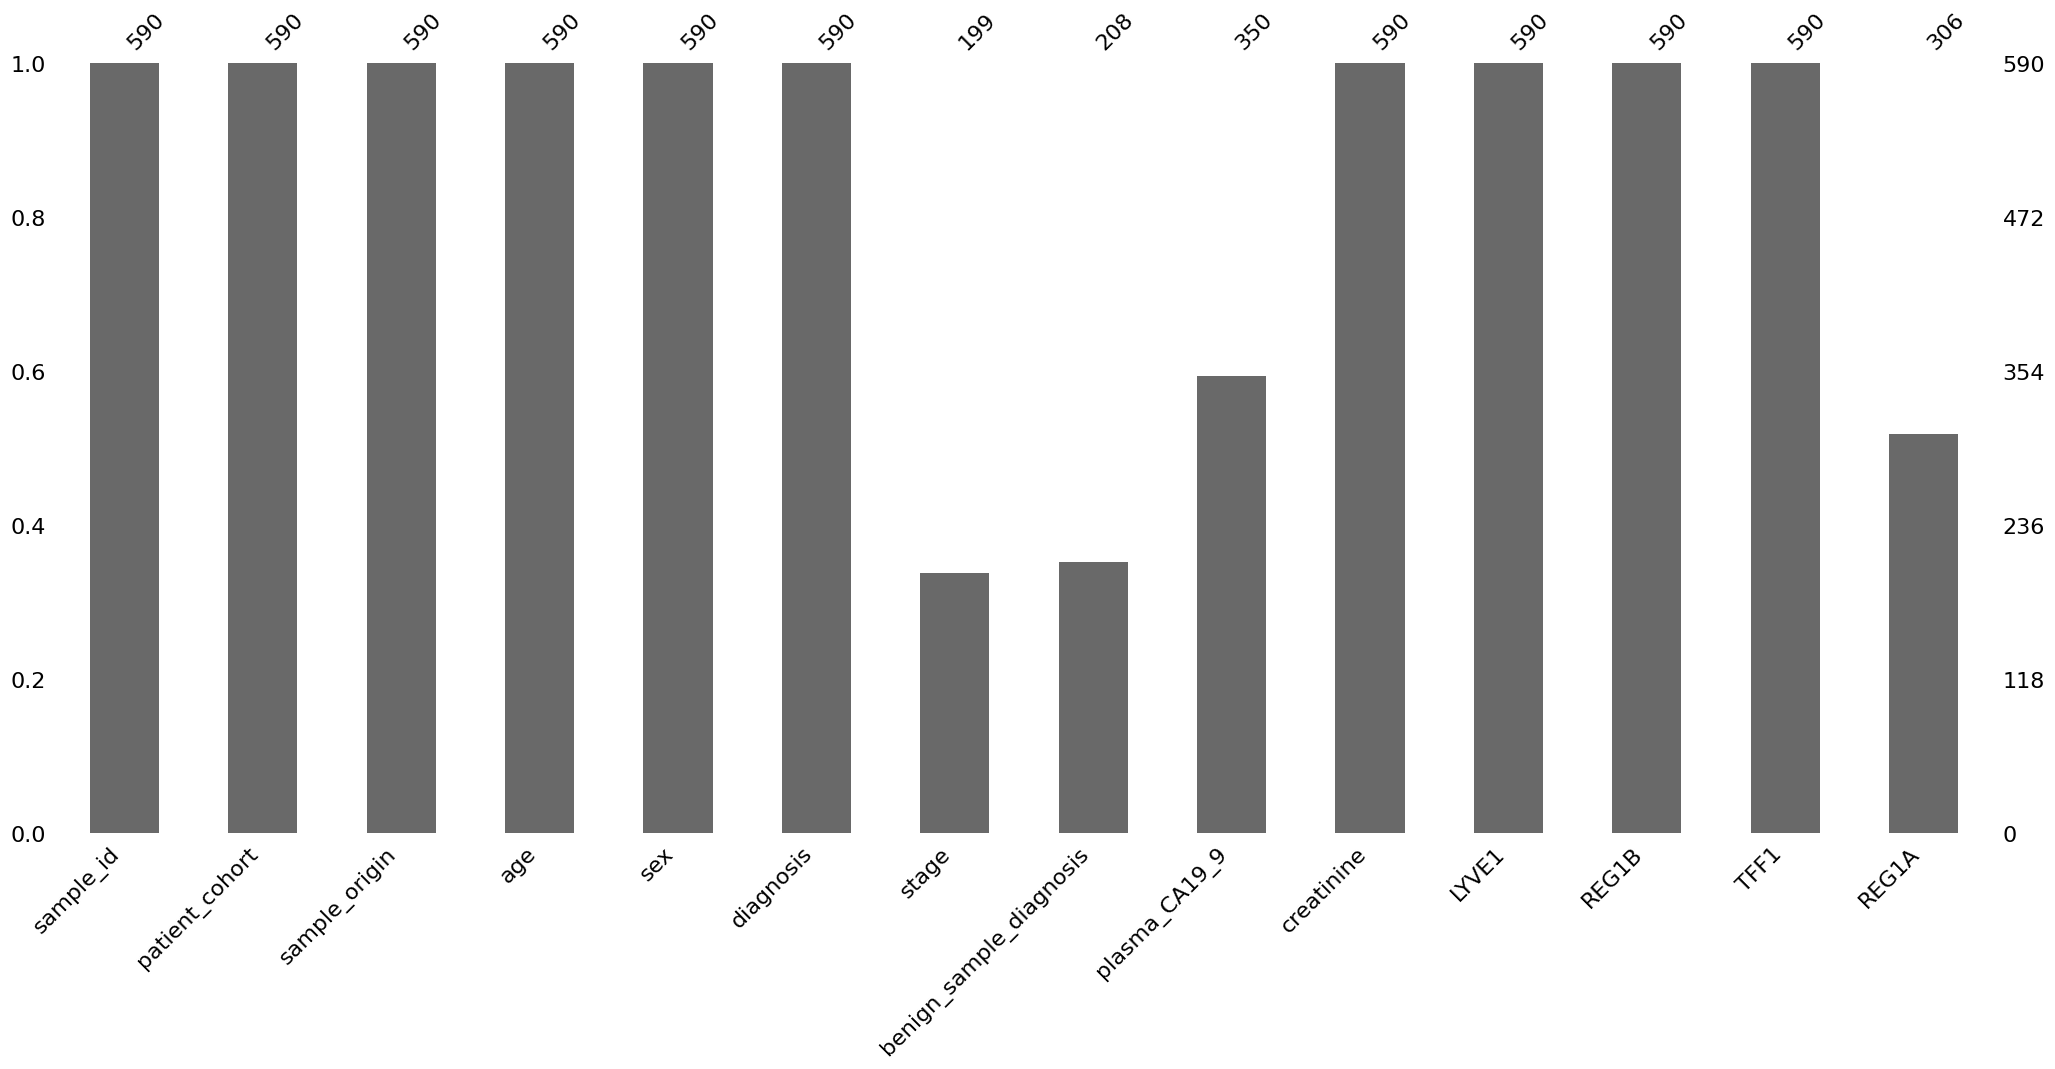

In [ ]:
# Visualization of Missing Data

msno.bar(df); # This graph visually represents the proportion of missing values in variables.

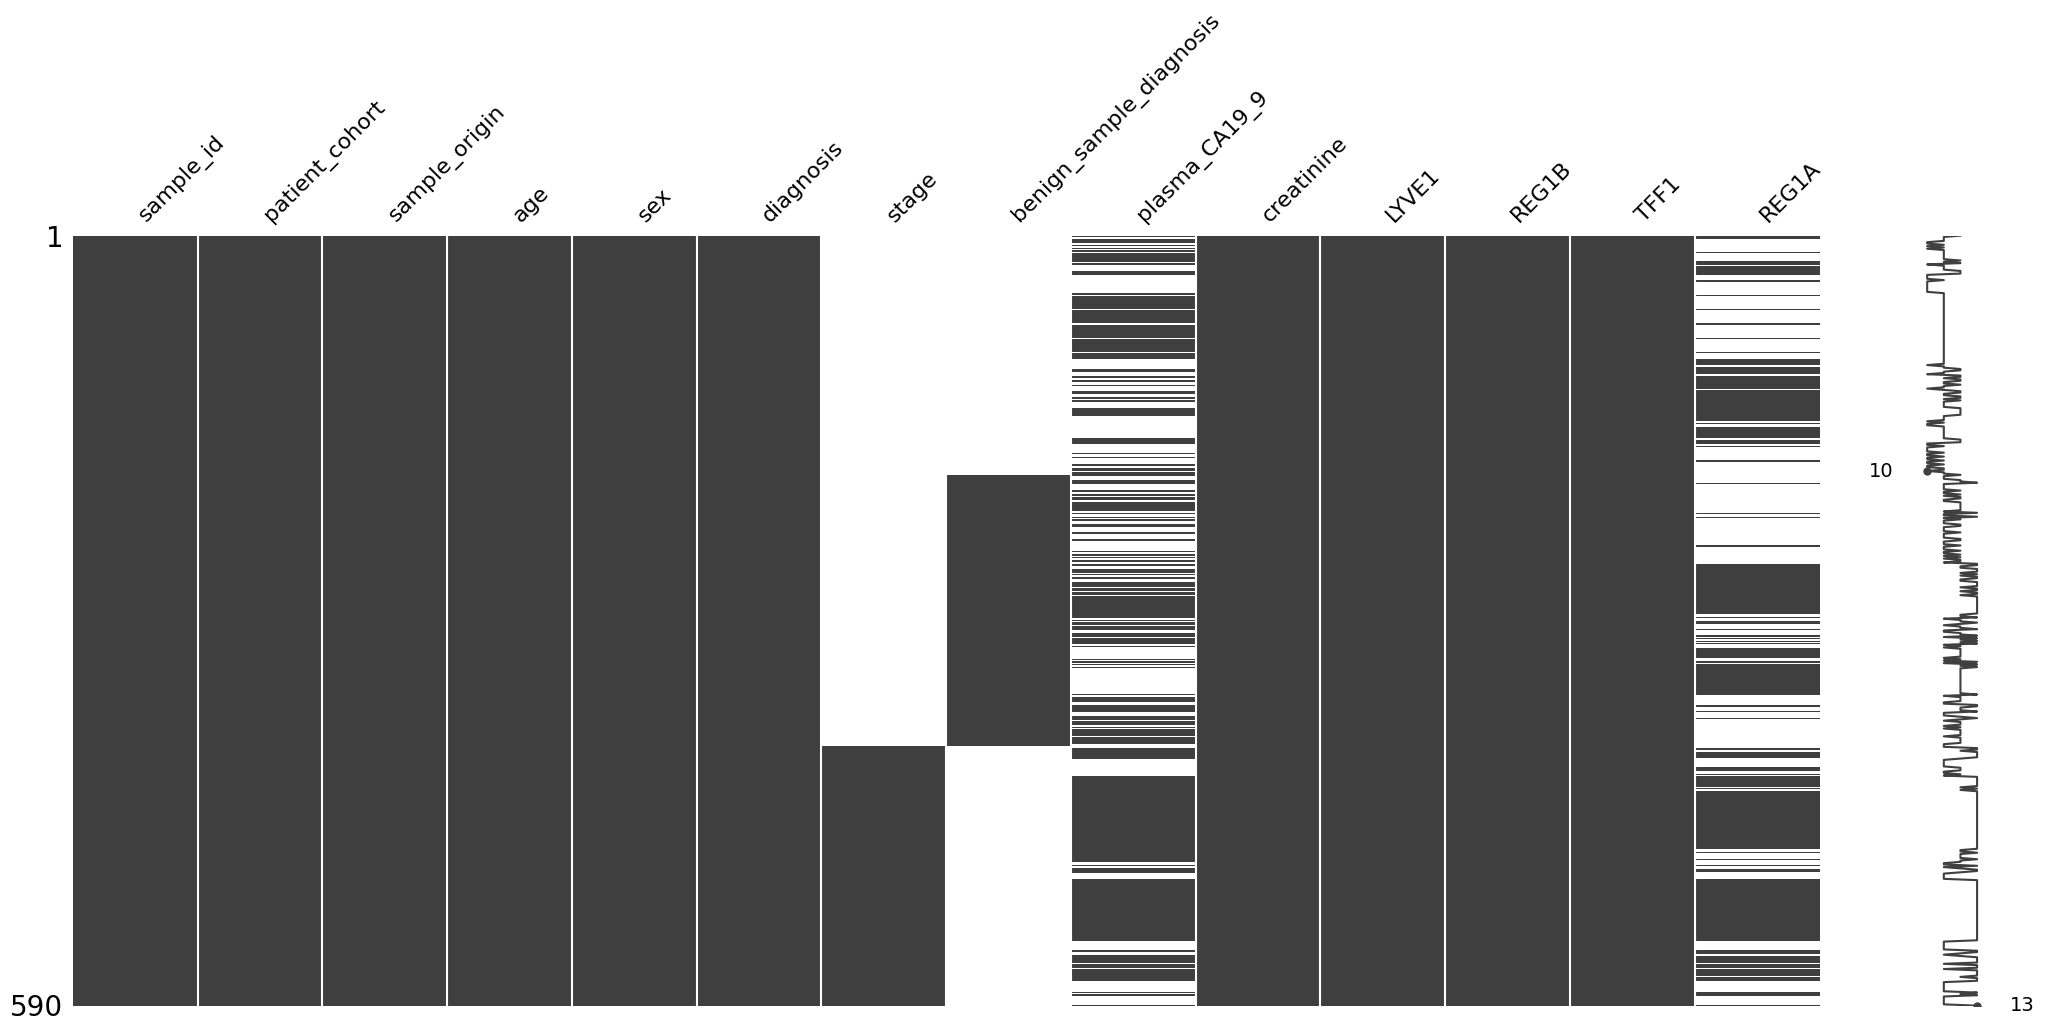

In [ ]:
msno.matrix(df); # This graph allows us to detect structural irregularities related to the randomness of missing values.

# Data Preprocessing

## Data Type Fromat

In [ ]:
# The transformation of the 'sex' variable into 0-1 typically involves assigning numerical values to categories, often used globally.

df["sex"] = df['sex'].replace(['F','M'],[0,1])
print(df.sex.head())
print("\n\n***********************\n")
print("Siniflarin Sayisi :\n\n{0}".format(df.sex.value_counts()))

0    0
1    0
2    1
3    1
4    1
Name: sex, dtype: int64


***********************

Siniflarin Sayisi :

sex
0    299
1    291
Name: count, dtype: int64


In [ ]:
df.head() # First 5 observations.

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,0,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,0,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,1,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,1,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,1,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


In [ ]:
# Chort1 is assigned the value 1, and Chort2 is assigned the value 0.

df['patient_cohort'] = df['patient_cohort'].map({'Cohort1': 1, 'Cohort2': 0})
df['patient_cohort'] = pd.to_numeric(df['patient_cohort'], errors='coerce')
df['patient_cohort'].value_counts()

patient_cohort
1    332
0    258
Name: count, dtype: int64

In [ ]:
# The sample_origin variable has been converted to numerical values.

df['sample_origin'] = df['sample_origin'].map({'BPTB': 0, 'LIV': 1,'ESP': 2,'UCL': 3})
df['sample_origin'] = pd.to_numeric(df['sample_origin'], errors='coerce')
df["sample_origin"].value_counts()

sample_origin
0    409
1    132
2     29
3     20
Name: count, dtype: int64

In [ ]:
# Print columns to verify their existence
print(df.columns)

# Attempt to delete columns
columns_to_delete = ['stage', 'sample_id', 'benign_sample_diagnosis']
for col in columns_to_delete:
    if col in df.columns:
        del df[col]
    else:
        print(f"Column '{col}' not found in DataFrame.")


# Verify columns after deletion
print(df.columns)

Index(['sample_id', 'patient_cohort', 'sample_origin', 'age', 'sex',
       'diagnosis', 'stage', 'benign_sample_diagnosis', 'plasma_CA19_9',
       'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A'],
      dtype='object')
Index(['patient_cohort', 'sample_origin', 'age', 'sex', 'diagnosis',
       'plasma_CA19_9', 'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A'],
      dtype='object')


In [ ]:
df.isnull().sum() # How many missing observations are there in each variable

patient_cohort      0
sample_origin       0
age                 0
sex                 0
diagnosis           0
plasma_CA19_9     240
creatinine          0
LYVE1               0
REG1B               0
TFF1                0
REG1A             284
dtype: int64

In [ ]:
df.describe() # Statistical statements

,patient_cohort,sample_origin,age,sex,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
count,590.000000,590.000000,590.000000,590.000000,590.000000,350.000000,590.000000,590.000000,590.000000,590.000000,306.000000
mean,0.562712,0.423729,59.079661,0.493220,2.027119,654.002944,0.855383,3.063530,111.774090,597.868722,735.281222
std,0.496473,0.739462,13.109520,0.500378,0.804873,2430.317642,0.639028,3.438796,196.267110,1010.477245,1477.247724
min,0.000000,0.000000,26.000000,0.000000,1.000000,0.000000,0.056550,0.000129,0.001104,0.005293,0.000000
25%,0.000000,0.000000,50.000000,0.000000,1.000000,8.000000,0.373230,0.167179,10.757216,43.961000,80.692000
50%,1.000000,0.000000,60.000000,0.000000,2.000000,26.500000,0.723840,1.649862,34.303353,259.873974,208.538500
75%,1.000000,1.000000,69.000000,1.000000,3.000000,294.000000,1.139482,5.205037,122.741013,742.736000,649.000000
max,1.000000,3.000000,89.000000,1.000000,3.000000,31000.000000,4.116840,23.890323,1403.897600,13344.300000,13200.000000


In [ ]:
# Divided the dataset according to the 'diagnosis' variable - we need to fill in the missing values.

diag1 = pd.DataFrame(df[df.diagnosis==1])
diag2 = pd.DataFrame(df[df.diagnosis==2])
diag3 = pd.DataFrame(df[df.diagnosis==3])

In [ ]:
df.isnull().sum()

patient_cohort      0
sample_origin       0
age                 0
sex                 0
diagnosis           0
plasma_CA19_9     240
creatinine          0
LYVE1               0
REG1B               0
TFF1                0
REG1A             284
dtype: int64

In [ ]:
# We filled in the missing plasma_CA19_9 with the mean.

diag1['plasma_CA19_9'].fillna(int(diag1['plasma_CA19_9'].mean()), inplace=True)
diag2['plasma_CA19_9'].fillna(int(diag2['plasma_CA19_9'].mean()), inplace=True)
diag3['plasma_CA19_9'].fillna(int(diag3['plasma_CA19_9'].mean()), inplace=True)

In [ ]:
df.isnull().sum()

patient_cohort      0
sample_origin       0
age                 0
sex                 0
diagnosis           0
plasma_CA19_9     240
creatinine          0
LYVE1               0
REG1B               0
TFF1                0
REG1A             284
dtype: int64

In [ ]:
# We filled the missing REG1A with the mean.

diag1['REG1A'].fillna(int(diag1['REG1A'].mean()), inplace=True)
diag2['REG1A'].fillna(int(diag2['REG1A'].mean()), inplace=True)
diag3['REG1A'].fillna(int(diag3['REG1A'].mean()), inplace=True)

In [ ]:
diag1.isnull().sum()

patient_cohort    0
sample_origin     0
age               0
sex               0
diagnosis         0
plasma_CA19_9     0
creatinine        0
LYVE1             0
REG1B             0
TFF1              0
REG1A             0
dtype: int64

In [ ]:
# Merging the Data Set Separated by Patient Groups

Hasta_Olmayan = pd.concat([diag1, diag2], axis = 0)
Tum_Veri = pd.concat([Hasta_Olmayan, diag3], axis = 0)

In [ ]:
# Processed Data: All_Data

Tum_Veri.isnull().sum()

patient_cohort    0
sample_origin     0
age               0
sex               0
diagnosis         0
plasma_CA19_9     0
creatinine        0
LYVE1             0
REG1B             0
TFF1              0
REG1A             0
dtype: int64

## Outlier Analysis

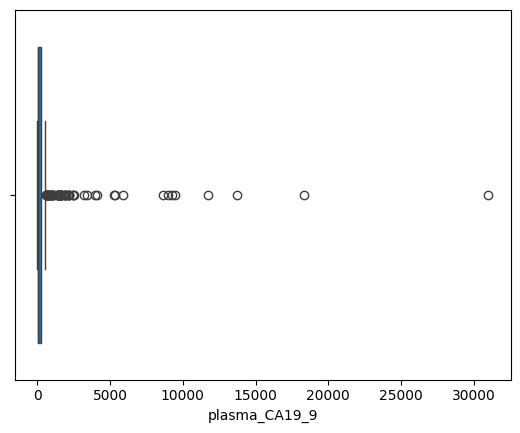

In [ ]:
sns.boxplot(x = Tum_Veri.plasma_CA19_9)

Q1 = Tum_Veri.plasma_CA19_9.quantile(0.25) # Retrieve the value corresponding to the 25th percentile when the variable is sorted in ascending order.
Q3 = Tum_Veri.plasma_CA19_9.quantile(0.75)

# Where the calculation is performed.

IQR = Q3 - Q1

In [ ]:
Q1 # observe.

8.0

In [ ]:
Q3 # observe.

227.25

In [ ]:
IQR # observe.

219.25

In [ ]:
alt_sinir = Q1 - 1.5 * IQR # Setting the lower bound as the First Quartile value minus (1.5 * IQR) means defining it as the threshold value.
ust_sinir = Q3 + 1.5 * IQR

In [ ]:
alt_sinir # observe.

-320.875

In [ ]:
ust_sinir # observe.

556.125

In [ ]:
# Our goal is to reach outliers (Let's start step by step).

Tum_Veri.plasma_CA19_9 < alt_sinir # This boolean query was executed for each observation.

0      False
1      False
2      False
3      False
4      False
       ...  
585    False
586    False
587    False
588    False
589    False
Name: plasma_CA19_9, Length: 590, dtype: bool

In [ ]:
# We queried for values either below the lower bound or above the upper bound.

(Tum_Veri.plasma_CA19_9 < alt_sinir) | (Tum_Veri.plasma_CA19_9 > ust_sinir) # Those meeting this condition receive a "True" value, while those who don't receive a "False" value.

# Right now, we've just queried this.

0      False
1      False
2      False
3      False
4      False
       ...  
585     True
586     True
587     True
588     True
589     True
Name: plasma_CA19_9, Length: 590, dtype: bool

In [ ]:
aykiri_tf = (Tum_Veri.plasma_CA19_9 < alt_sinir) # An "Outlier" Boolean variable

aykiri_tf.head()

0    False
1    False
2    False
3    False
4    False
Name: plasma_CA19_9, dtype: bool

In [ ]:
aykiri_tf.value_counts()

plasma_CA19_9
False    590
Name: count, dtype: int64

In [ ]:
aykiri_tf = (Tum_Veri.plasma_CA19_9 > ust_sinir) # A variable named Outlier True False

aykiri_tf.head()

0    False
1    False
2    False
3    False
4    False
Name: plasma_CA19_9, dtype: bool

In [ ]:
aykiri_tf.value_counts()

plasma_CA19_9
False    479
True     111
Name: count, dtype: int64

In [ ]:
# access the outlier elements using the fancy indexing method.

Tum_Veri.plasma_CA19_9[aykiri_tf] # [] display those with True inside the expression

267    1541.0
277    1913.0
391    1476.0
395    3236.0
400    5335.0
        ...  
585    1476.0
586    1476.0
587    1476.0
588    1476.0
589    1488.0
Name: plasma_CA19_9, Length: 111, dtype: float64

In [ ]:
# access the indices of outlier elements like this

Tum_Veri.plasma_CA19_9[aykiri_tf].index

Index([267, 277, 391, 395, 400, 401, 402, 403, 404, 405,
       ...
       580, 581, 582, 583, 584, 585, 586, 587, 588, 589],
      dtype='int64', length=111)

## To resolve the outlier problem

In [ ]:
Tum_Veri.plasma_CA19_9.mean()

522.1237802063051

In [ ]:
# Caught the outliers and replaced them with the mean (ignoring the warning)

Tum_Veri.plasma_CA19_9[aykiri_tf] = Tum_Veri.plasma_CA19_9.mean()

In [ ]:
# Observed that the assignment operation was successful

Tum_Veri.plasma_CA19_9[aykiri_tf]

267    522.12378
277    522.12378
391    522.12378
395    522.12378
400    522.12378
         ...    
585    522.12378
586    522.12378
587    522.12378
588    522.12378
589    522.12378
Name: plasma_CA19_9, Length: 111, dtype: float64

# Data Visualization

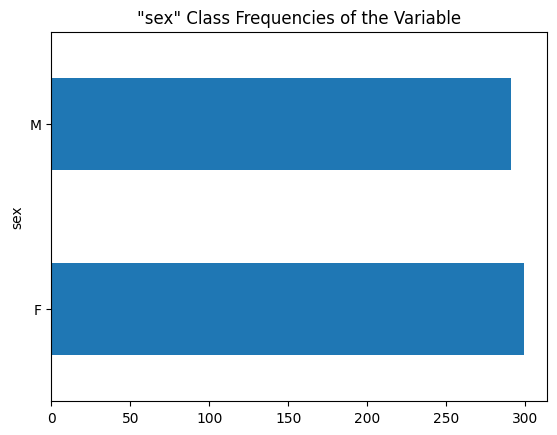

In [ ]:
Pancreatic_Cancer["sex"].value_counts().plot.barh().set_title("\"sex\" Class Frequencies of the Variable");
# The number of women is greater than the number of men.

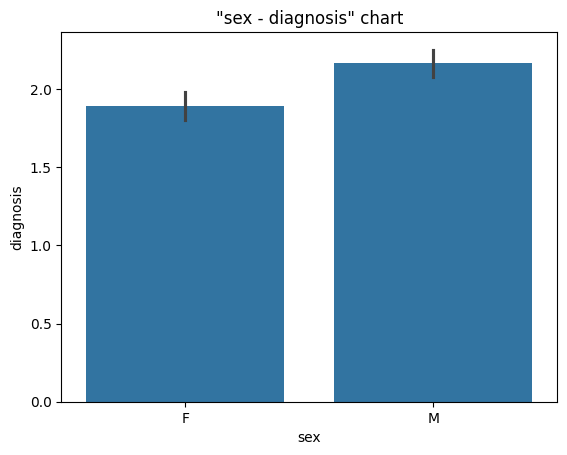

In [ ]:
sns.barplot(x = Pancreatic_Cancer.sex, y = "diagnosis", data = Pancreatic_Cancer).set_title("\"sex - diagnosis\" chart");
# It is observed that there are more male patients compared to females.

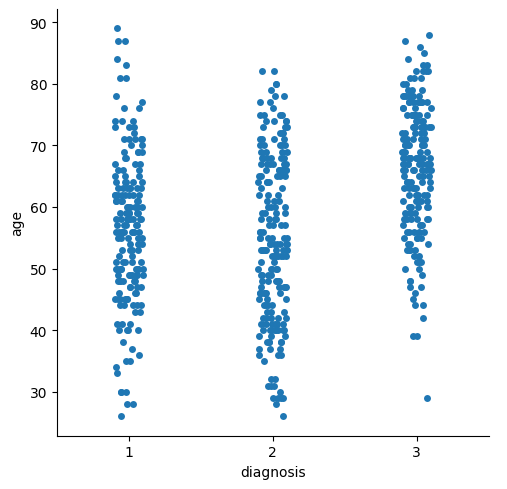

In [ ]:
sns.catplot(x = "diagnosis", y = "age", data = Tum_Veri);
# Proportionally, it is observed that those with cancer are older in age.

#### patient cohort = patient group

* Cohort 1, previously used samples
* Cohort 2, newly added samples

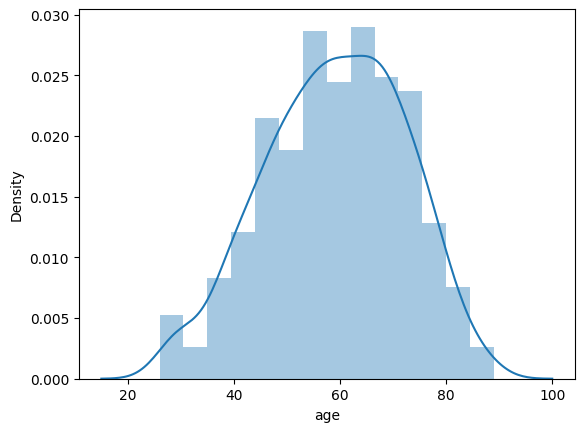

In [ ]:
sns.distplot(Tum_Veri.age, kde = True);
# When looking at the age variable, it is observed to be concentrated around 60.

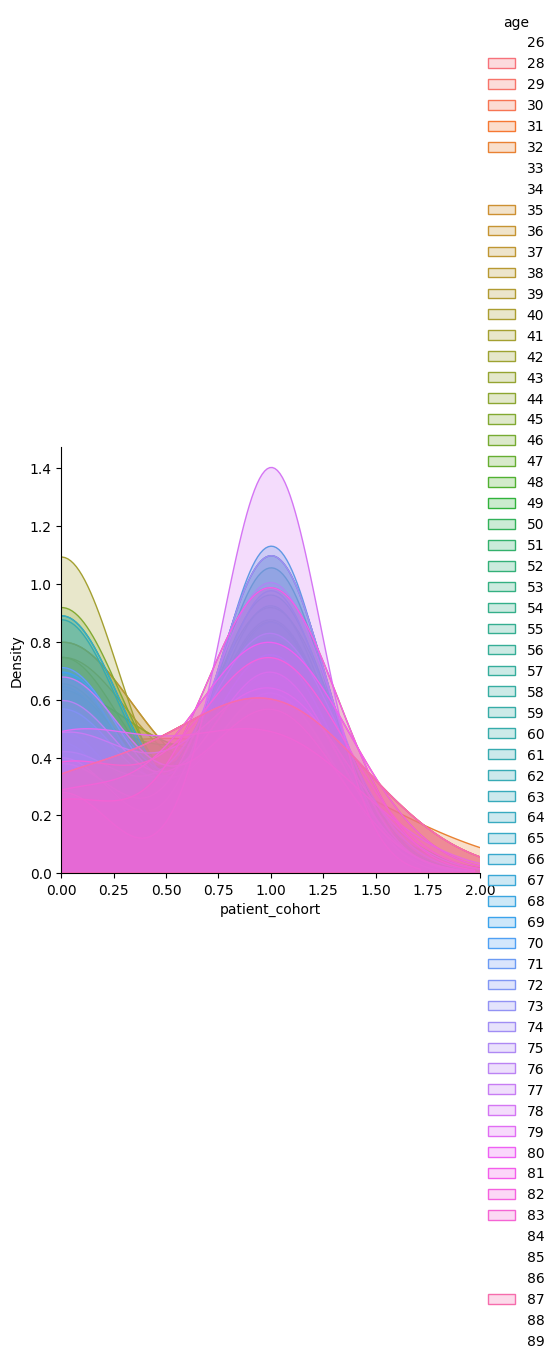

In [ ]:
# ================   get more details
sns.FacetGrid(Tum_Veri,
           hue = "age",# Adding Dimension
           height = 5,
           xlim = (0,2)) \
.map(sns.kdeplot, "patient_cohort", shade = True) \
.add_legend() # It is used to add information

# Kernel Density Plot of Patient Cohorts by Age

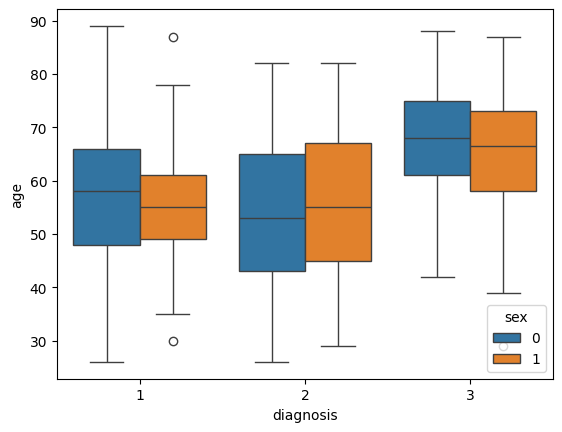

In [ ]:
sns.boxplot(x = "diagnosis", y = "age", hue = "sex", data = Tum_Veri);


#### The classes for the sex variable typically include:

* F : 0
* M : 1

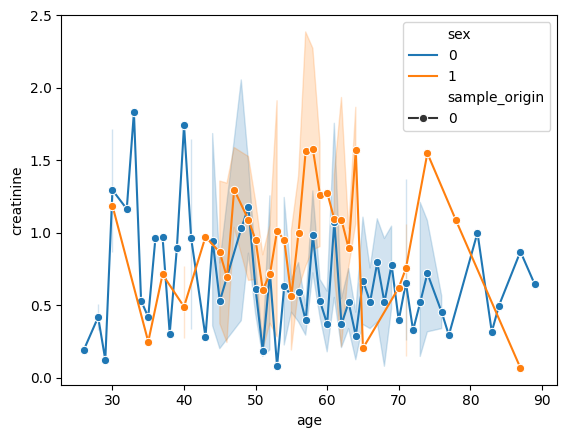

In [ ]:
sns.lineplot(x = "age",
             y = "creatinine",
             hue = "sex",
             style = "sample_origin",
             markers = True, dashes = False, data = Tum_Veri[0:200]);

In [ ]:
Tum_Veri.corr() # Distribution and correlations of variables

,patient_cohort,sample_origin,age,sex,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
patient_cohort,1.000000,0.477822,0.100835,0.227245,0.305896,0.261476,0.225134,0.401192,0.131202,0.203987,0.114860
sample_origin,0.477822,1.000000,0.152736,0.140843,0.377172,0.299825,0.143942,0.355987,0.156101,0.235491,0.001299
age,0.100835,0.152736,1.000000,0.024023,0.308251,0.331992,-0.069393,0.329805,0.204317,0.207868,0.088950
sex,0.227245,0.140843,0.024023,1.000000,0.169081,0.128750,0.180059,0.177008,0.157579,0.114623,0.126071
diagnosis,0.305896,0.377172,0.308251,0.169081,1.000000,0.729419,0.074888,0.540384,0.383516,0.392613,0.337301
plasma_CA19_9,0.261476,0.299825,0.331992,0.128750,0.729419,1.000000,0.067453,0.538363,0.400795,0.384634,0.320555
creatinine,0.225134,0.143942,-0.069393,0.180059,0.074888,0.067453,1.000000,0.338533,0.261906,0.397795,0.080645
LYVE1,0.401192,0.355987,0.329805,0.177008,0.540384,0.538363,0.338533,1.000000,0.543075,0.577363,0.306500
REG1B,0.131202,0.156101,0.204317,0.157579,0.383516,0.400795,0.261906,0.543075,1.000000,0.690228,0.419841
TFF1,0.203987,0.235491,0.207868,0.114623,0.392613,0.384634,0.397795,0.577363,0.690228,1.000000,0.336611


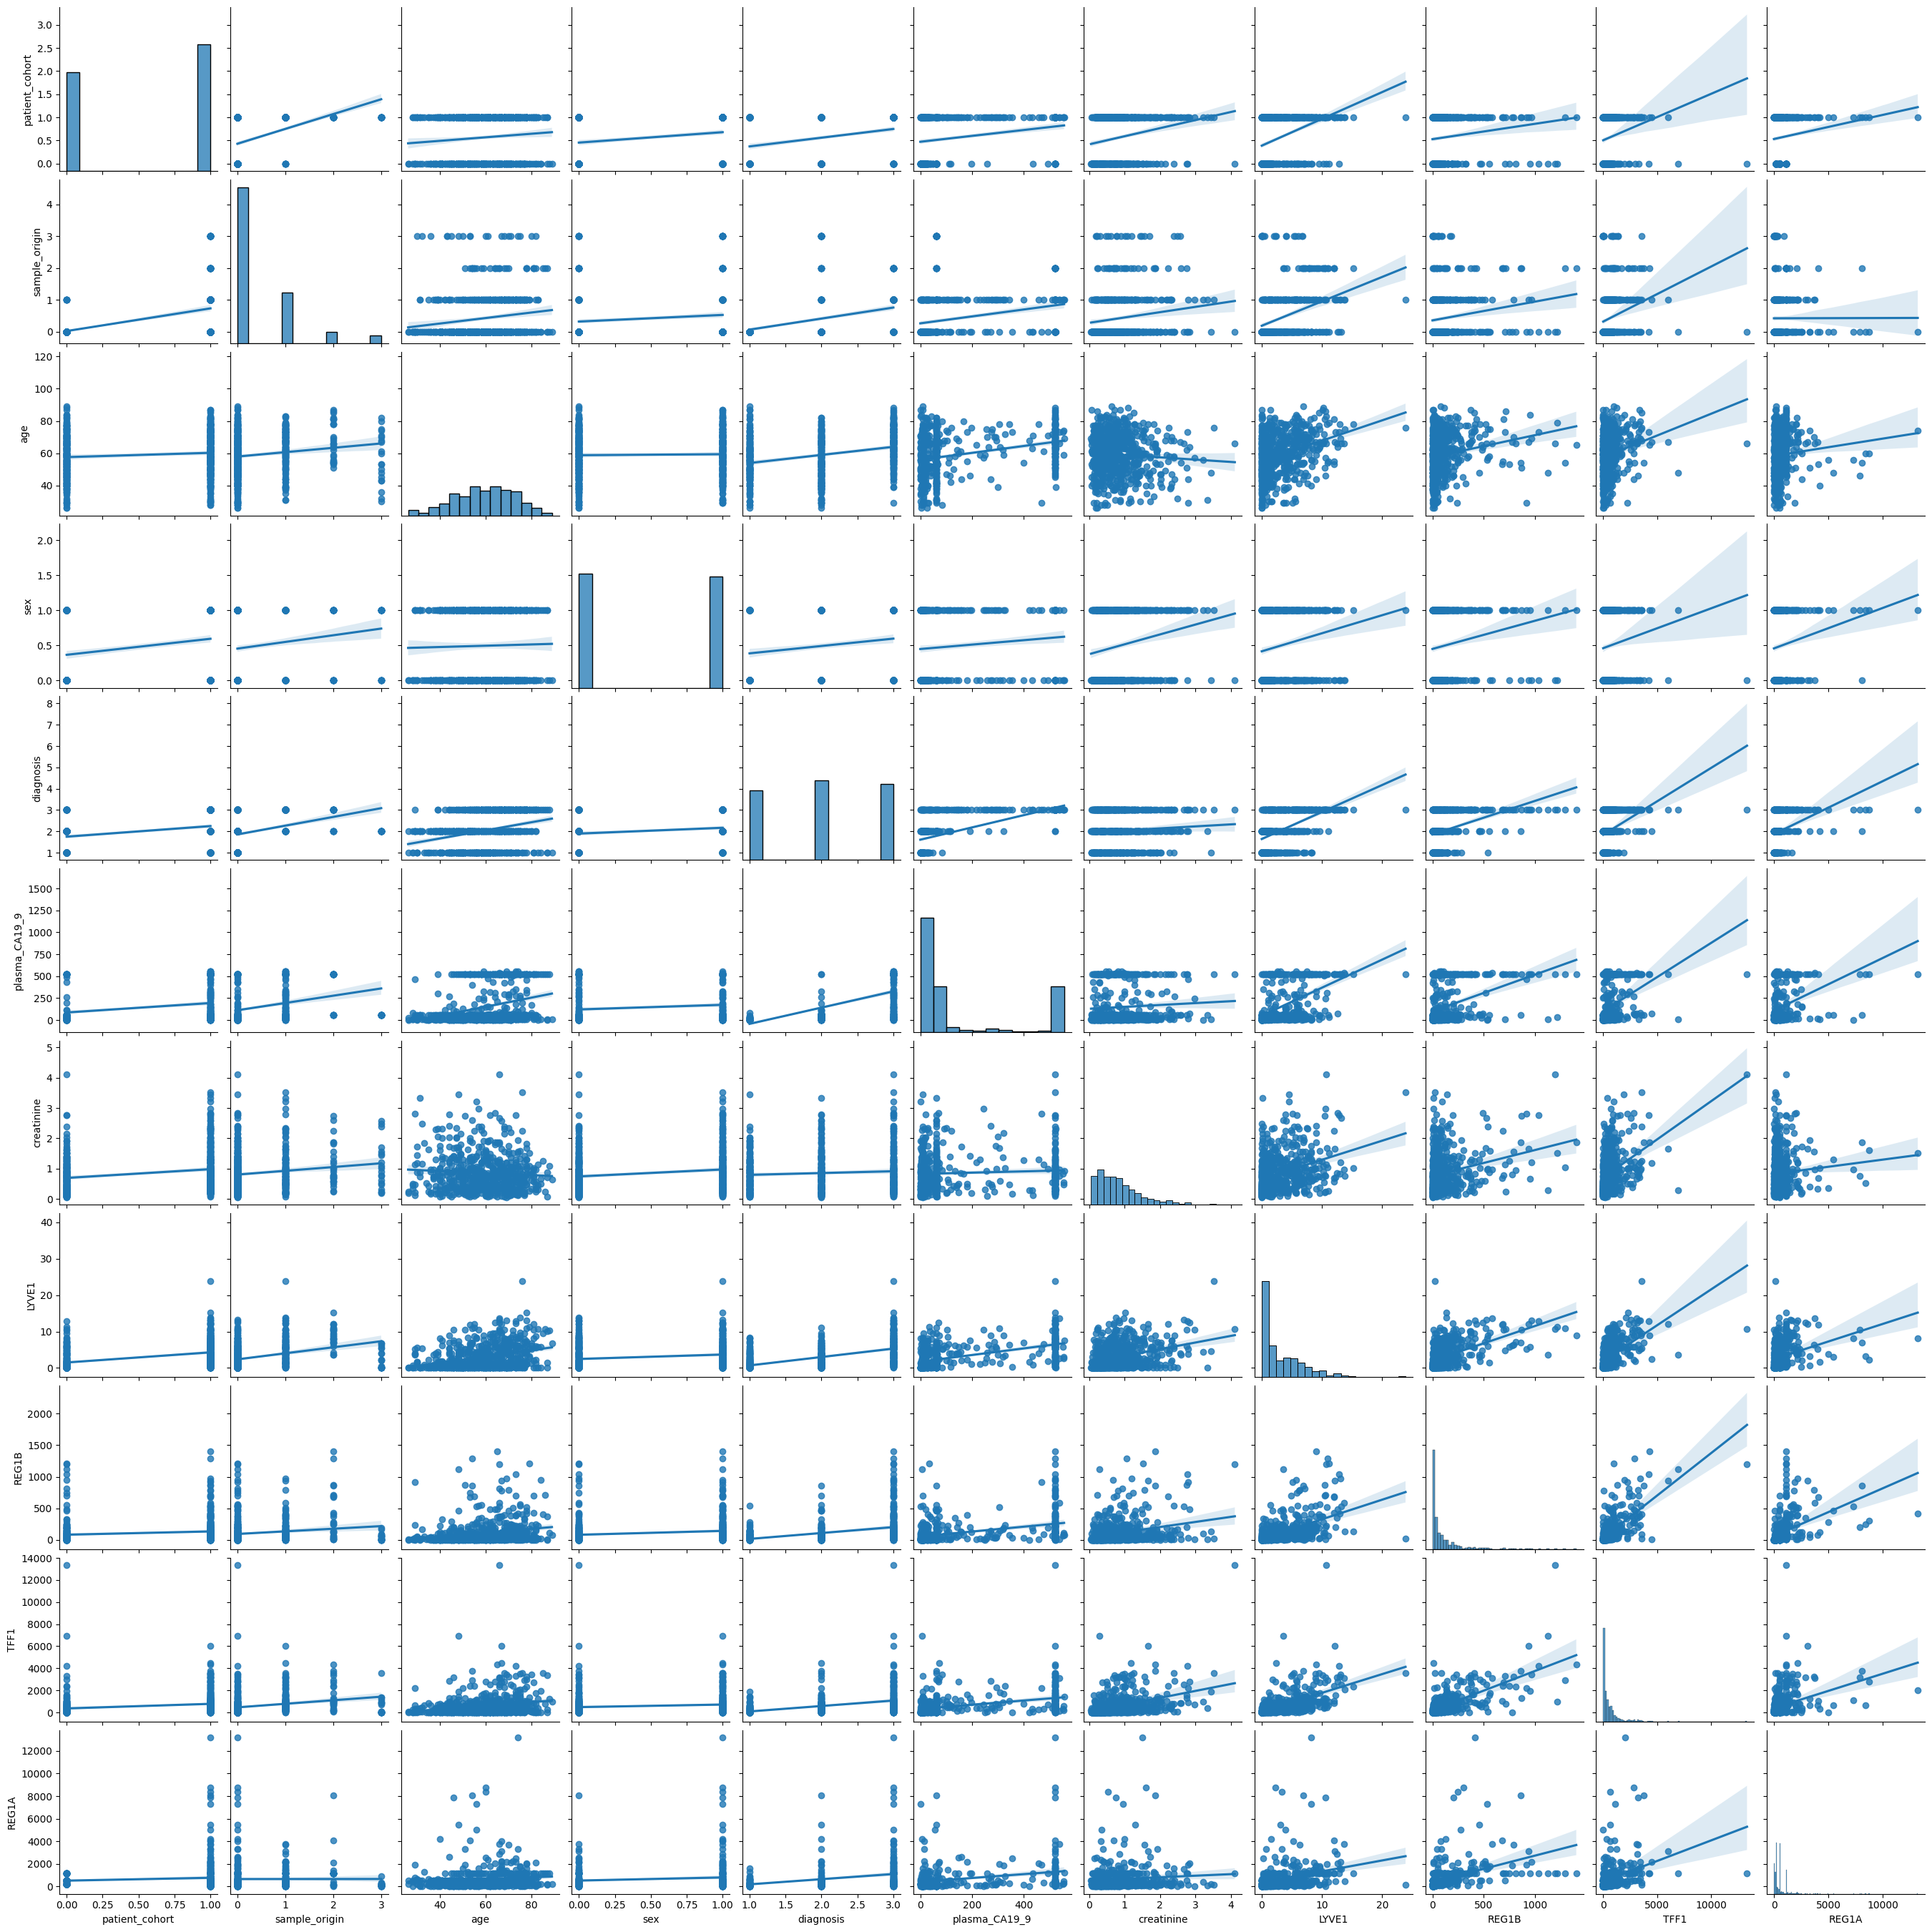

In [ ]:
sns.pairplot(Tum_Veri, kind  ="reg");
# Correlations of variables

# Machine learning model (2-Models)
##### Three-part Form of the Dataset
 * Diagnosis (Diagnosis) Classes
    * 1 = control (no pancreatic disease)
    * 2 = benign hepatobiliary disease (119 is chronic pancreatitis)
    * 3 = pancreatic cancer (Patient)

In [ ]:
df = Tum_Veri.copy() # copied the original dataset to preserve its structure

X = df.drop(["diagnosis"], axis=1) # The dataset with the target variable removed
y = df["diagnosis"] # The target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=63) # split dataset

In [ ]:
print("X_train", X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)
print("Tum Veri", Tum_Veri.shape)

X_train (472, 10)
y_train (472,)
X_test (118, 10)
y_test (118,)
Tum Veri (590, 11)


## CART

In [ ]:
df = Tum_Veri.copy()

X = df.drop(["diagnosis"], axis=1)
y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=63)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
cart = DecisionTreeClassifier()
cart_model = cart.fit(X_train, y_train)

In [ ]:
y_pred = cart_model.predict(X_test)

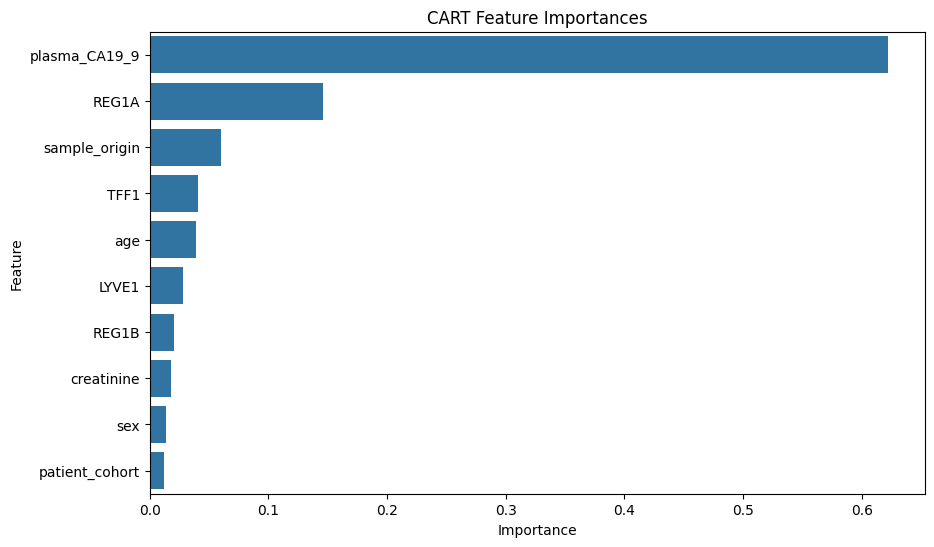

In [ ]:
# Get feature importances
feature_importances_cart = cart_model.feature_importances_
features = X.columns

# Create a DataFrame for better visualization
feature_importance_df_cart = pd.DataFrame({'Feature': features, 'Importance': feature_importances_cart})
feature_importance_df_cart = feature_importance_df_cart.sort_values(by='Importance', ascending=False)

# print("CART Feature Importances:")
# print(feature_importance_df_cart)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_cart)
plt.title('CART Feature Importances')
plt.show()

In [ ]:
# evaluation performance of CART
CART_Accuracy = accuracy_score(y_test, y_pred)
CART_conf_matrix = confusion_matrix(y_test, y_pred)
CART_conf_report = classification_report(y_test, y_pred)

## Category Boosting (CatBoost)

In [ ]:
df = Tum_Veri.copy()

X = df.drop(["diagnosis"], axis=1)
y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=63)

In [ ]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier().fit(X_train, y_train)

Learning rate set to 0.076154
0:	learn: 1.0174829	total: 54ms	remaining: 53.9s
1:	learn: 0.9548575	total: 57.8ms	remaining: 28.8s
2:	learn: 0.8964688	total: 61.8ms	remaining: 20.5s
3:	learn: 0.8467154	total: 65.9ms	remaining: 16.4s
4:	learn: 0.8073814	total: 70ms	remaining: 13.9s
5:	learn: 0.7649553	total: 73.7ms	remaining: 12.2s
6:	learn: 0.7254459	total: 77.6ms	remaining: 11s
7:	learn: 0.6906436	total: 81.8ms	remaining: 10.1s
8:	learn: 0.6644139	total: 85.6ms	remaining: 9.42s
9:	learn: 0.6398060	total: 89.4ms	remaining: 8.85s
10:	learn: 0.6142111	total: 93.3ms	remaining: 8.39s
11:	learn: 0.5897231	total: 97.3ms	remaining: 8.01s
12:	learn: 0.5651044	total: 101ms	remaining: 7.67s
13:	learn: 0.5477112	total: 105ms	remaining: 7.41s
14:	learn: 0.5284672	total: 109ms	remaining: 7.18s
15:	learn: 0.5115973	total: 113ms	remaining: 6.96s
16:	learn: 0.4961874	total: 117ms	remaining: 6.76s
17:	learn: 0.4818982	total: 121ms	remaining: 6.59s
18:	learn: 0.4682859	total: 125ms	remaining: 6.44s
19:	l

In [ ]:
y_pred = cat_model.predict(X_test)

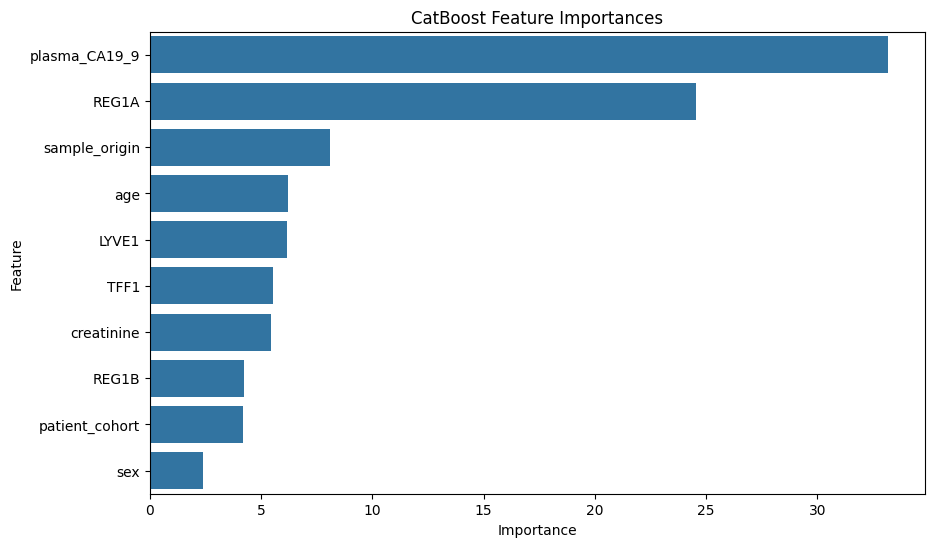

In [ ]:
# Get feature importances
CatBoost_feature_importances = cat_model.get_feature_importance(Pool(X, label=y))
CatBoost_features = X.columns

# Create a DataFrame for better visualization
CatBoost_feature_importance_df = pd.DataFrame({'Feature': CatBoost_features, 'Importance': CatBoost_feature_importances})
CatBoost_feature_importance_df = CatBoost_feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances for CatBoost
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=CatBoost_feature_importance_df)
plt.title('CatBoost Feature Importances')
plt.show()

In [ ]:
# evaluation performance of CatBoost
CatBoost_Accuracy = accuracy_score(y_test, y_pred)
CatBoost_conf_matrix = confusion_matrix(y_test, y_pred)
CatBoost_conf_report = classification_report(y_test, y_pred)

### Performance Matrics Results

In [ ]:
print("CART_Accuracy : {0}\n\nCatBoost_Accuracy : {1} \n\n".format(CART_Accuracy, CatBoost_Accuracy))
print("CART_conf_matrix :\n {0}\n\nCatBoost_conf_matrix :\n {1}\n\n".format(CART_conf_matrix, CatBoost_conf_matrix))
print("CART_report : \n{0}\n\nCatBoost_report :\n {1}".format(CART_conf_report, CatBoost_conf_report))

CART_Accuracy : 0.8898305084745762

CatBoost_Accuracy : 0.9576271186440678 


CART_conf_matrix :
 [[40  3  0]
 [ 0 35  4]
 [ 0  6 30]]

CatBoost_conf_matrix :
 [[43  0  0]
 [ 0 37  2]
 [ 1  2 33]]


CART_report : 
              precision    recall  f1-score   support

           1       1.00      0.93      0.96        43
           2       0.80      0.90      0.84        39
           3       0.88      0.83      0.86        36

    accuracy                           0.89       118
   macro avg       0.89      0.89      0.89       118
weighted avg       0.90      0.89      0.89       118


CatBoost_report :
               precision    recall  f1-score   support

           1       0.98      1.00      0.99        43
           2       0.95      0.95      0.95        39
           3       0.94      0.92      0.93        36

    accuracy                           0.96       118
   macro avg       0.96      0.96      0.96       118
weighted avg       0.96      0.96      0.96       118

